# Abstract

We study a variation of the Homicidal Chauffeur Problem in 2D, a differential game where a prey is chased by a predator. In the general setting, the prey is more agile while the predator is faster: we interpret it as giving the prey higher acceleration, while the predator has greater maximum speed. We first study the interactions for a naive strategy pair: the prey evades through right angle acceleration, while the predator accelerates in response to the prey's current position by following the Proportional Navigation (PN) algorithm. We compare metrics relevant to specific trajectories and use fourier analysis to study the natural frequencies of the trajectories. We then fix the initial conditions for the runs and use statistical properties to study a larger sample of trajectories as we vary the balance between predator velocity and prey acceleration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import clear_output
import time
import math
from numba import njit
import scipy

# General Setting
We first consider a simple model for behavior of both predator and prey. For the sake of understanding, we will initialize the simulation with prey at maximum velocity, pointing at different angles (bearings), and predator at rest. 

With the initial conditions being the following:

$\left\{
\begin{aligned}
    x(0) &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
    y(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.
\hspace{3em}
\left\{
\begin{aligned}
    \dot{x}(0) &= 
    \begin{bmatrix}
        \cos\theta & -\sin\theta \\
        \sin\theta & \cos\theta
    \end{bmatrix}
    \begin{pmatrix}
        v^x_{\text{max}} \\
        0
    \end{pmatrix} \\
    \dot{y}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.$


$\left\{
\begin{aligned}
    \ddot{x}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix} \\
    \ddot{y}(0) &= \begin{pmatrix} 0 \\ 0 \end{pmatrix}
\end{aligned}
\right.$

In [2]:
@njit
def get_trajectory(deg: float, n_steps: int, prey_speed_max: float, pred_speed_max: float):
    """
    Initialize a trajectory state array for a 2D predator-prey simulation.

    The state array has shape (n_steps, 2 agents, 3 features, 2 dimensions), where:
    - time: t in {0, ..., n_steps - 1}
    - agents: 0 = predator, 1 = prey
    - features: 0 = position, 1 = velocity, 2 = acceleration
    - dimensions: 2D (x, y)

    Args:
        deg (float): Direction angle (in degrees) of prey's initial velocity.
        params (dict): Dictionary containing simulation parameters including 'n_steps' and '11_max' (prey's max speed).

    Returns:
        np.ndarray: Initialized state array.
    """
    
    state = np.zeros((n_steps, 2, 3, 2), dtype=float)

    # initial predator pos, vel, acc
    state[0, 0, 0] = [0, 0] 
    state[0, 0, 1] = [pred_speed_max, 0] 
    state[0, 0, 2] = [0, 0] 

    rad = np.deg2rad(deg) 

    # initial prey pos, vel, acc
    state[0, 1, 0] = [10, 0]
    state[0, 1, 1] = [np.sin(rad) * prey_speed_max, np.cos(rad) * prey_speed_max]
    state[0, 1, 2] = [0, 0] 
    
    return state

As a data object, we use a 'state' numpy tensor to precompute the trajectory, before plotting it in its entirety.

Written formally, the simulation produces the trajectory tuple $(x,y)(t)\in \mathbb{R}^2 \times \mathbb{R}^2 \times \mathbb{R}^+$. Moreover, the equations of motion for both prey (x) and predator (y) are defined solely by their acceleration.


In [3]:
@njit
def norm(v):
    return np.sqrt(np.sum(v ** 2))

@njit
def norm_list(v):
    out = np.empty(v.shape[0])
    for i in range(v.shape[0]):
        out[i] = np.sqrt(v[i, 0] ** 2 + v[i, 1] ** 2)
    return out

@njit
def normalize(v):
    length = norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

@njit
def rotate_right_90(v):
    """Rotate a 2D vector 90 degrees to the right (clockwise)."""
    return np.array([v[1], -v[0]])

@njit
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

On a more concrete note, we use Euler Integration despite its $O(t^2)$ error rate, as it is easily computable and simple to implement.

## Prey Behaviour
Throughout the simulation, the prey maintains its acceleration, only changing it if the predator gets within the prey's reaction distance.

$
\begin{aligned}
    \ddot{x}(t) &= 
    \begin{cases}
        a^{\text{max}}_x
        \begin{bmatrix}
            0 & -1 \\
            1 & 0
        \end{bmatrix}
        \dfrac{y(t) - x(t)}{\|y(t) - x(t)\|} 
        & \|x(t) - y(t)\| < R_{\text{react}} \\[1.2em]
        \ddot{x}(t^*_{\text{last react}}) 
        & \|x(t) - y(t)\| \geq R_{\text{react}}
    \end{cases} \\
\end{aligned}$

In [4]:
@njit
def step(state, t, dt, pred_speed_max, prey_speed_max):
    """
    Update position and velocity for timestep t based on previous state.
    Applies max speed limits separately for predator (agent 0) and prey (agent 1).
    """
    # Position update
    state[t, :, 0, :] = state[t-1, :, 0, :] + state[t-1, :, 1, :] * dt

    # Velocity update
    state[t, :, 1, :] = state[t-1, :, 1, :] + state[t-1, :, 2, :] * dt

    # Limit predator speed
    pred_speed = norm(state[t, 0, 1, :])
    if pred_speed > pred_speed_max:
        state[t, 0, 1, :] = state[t, 0, 1, :] / pred_speed * pred_speed_max

    # Limit prey speed
    prey_speed = norm(state[t, 1, 1, :])
    if prey_speed > prey_speed_max:
        state[t, 1, 1, :] = state[t, 1, 1, :] / prey_speed * prey_speed_max

    return state

## Predator Behaviour

We model the predator through the "Proportional Navigation" algorithm, which is typically used as a guidance law for tactical homing missiles. It induces lateral acceleration in missiles, proportional to the rate of change of the line of sight (LOS). Through this mechanism, the missile's velocity vector rotates constantly, up to interception. The predator thus accelerates in a direction orthogonal to the line-of-sight vector, with strength proportional to the rate at which the angle between it and the prey changes.

$\ddot{y}(t) = N \cdot v_c(t) \cdot \dot{\lambda}(t) \cdot \begin{bmatrix} -\hat{r}_y \\ \hat{r}_x \end{bmatrix}$

In order to compute instantaneous acceleration, the algorithm uses measurements of the LOS angular rate and computes the closing velocity between the missile and the target. In our case, the LOS vector is calculated by taking `prey_pos - pred_pos`, which can then be divided by the distance between the predator and prey, obtaining a unit LOS vector. The closing velocity is then found by taking the dot product of the `LOS_unit` and the relative velocity `v_rel`. 

The terms of the proportional acceleration formula are the following:

- $\hat{r}(t) = \frac{x(t) - y(t)}{\|x(t) - y(t)\|}$ is the unit vector pointing from predator to prey,
- $\dot{\lambda}(t)$ is the _line-of-sight (LOS) angular rate_, given by

  $$
  \dot{\lambda}(t) = \frac{r_x \cdot \Delta v_y - r_y \cdot \Delta v_x}{\|x(t) - y(t)\|^2}
  $$

  where $\Delta v = \dot{x}(t) - \dot{y}(t)$,
- $v_c(t) = -\hat{r}(t) \cdot \Delta v$ is the _closing velocity_,
- $N$ is the _navigation constant_, typically chosen in the range 3–5.


Proportional navigation can guarantee interception of a target moving with constant velocity. However, if the target accelerates or changes direction, the mechanism may fail. The following will identify some cases where the algorithm fails, while giving an overview of methods that can be used to study the behaviour of the pursuit-evasion trajectories.

In [5]:
@njit
def proportional_navigation_acceleration(pred_pos, pred_vel, prey_pos, prey_vel, navigation_gain, pred_max_acc):
    r_vec = prey_pos - pred_pos # line of sight (LOS)
    v_rel = prey_vel - pred_vel # relative velocity

    dist = norm(r_vec)
    
    # Normalized line of sight vector
    los_unit = r_vec / dist
    
    # Cross product to get line of sight rotation rate
    los_rate = cross2d(r_vec, v_rel) / (dist ** 2)

    # Rotate los unit
    los_perp = np.array([-los_unit[1], los_unit[0]])
    
    # Proportional navigation acceleration
    acc_mag = navigation_gain * los_rate * norm(v_rel)

    acceleration = acc_mag * los_perp
    
    return acceleration

## Homicidial Chauffeur Assumptions

Throughout our investigation, we also impose the nonstrict inequalities of the Homicidial Chauffeur problem, which affect both acceleration and maximal velocities: the predator is faster, while the prey has a faster acceleration, making it more maneuvrable.

$\left\{
\begin{aligned}
    v^{\text{max}}_x \leq v^{\text{max}}_y \\
    a^{\text{max}}_x \geq a^{\text{max}}_y
\end{aligned}
\right.$

To both leverage Python's abstraction and Jupyter's interactivity, while speeding code generation, we used the _numba_ package to enable Just-In-Time compilation, speeding up calculations by an order of 20-40x, compared to the Python numpy operations.

In [6]:
def simulate(state, params):
    if params["R_kill"] == -1:
        return simul_nokill(state, params["dt"], params["R_react"], params["pred_acc"], params["prey_acc"], params["pred_max_speed"], params["prey_max_speed"], params['navigation_gain'])
    return simul(state, params["dt"], params["R_kill"], params["R_react"], params["pred_acc"], params["prey_acc"], params["pred_max_speed"], params["prey_max_speed"], params['navigation_gain'])

@njit
def simul(state, dt, r_kill, r_react, acc_pred, acc_prey, pred_max_speed, prey_max_speed, navigation_gain):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    n_steps = state.shape[0]

    for t in range(1, n_steps):
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        distance = norm(direction)

        if distance < r_kill:
            return state, t            
        elif distance < r_react:
            # Prey reacts: rotate predator-prey vector 90° right
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * acc_prey

        # Predator always steers toward prey
        state[t-1, 0, 2, :] = pred_acc_update(state, t, acc_pred, navigation_gain)

        # Step positions and velocities
        step(state, t, dt, pred_max_speed, prey_max_speed)

    return state, n_steps       

@njit
def simul_nokill(state, dt, r_react, acc_pred, acc_prey, pred_max_speed, prey_max_speed, navigation_gain):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    for t in range(1, state.shape[0]):
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        distance = norm(direction)

        if distance < r_react:
            # Prey reacts: rotate predator-prey vector 90° right
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * acc_prey

        state[t-1, 0, 2, :] = pred_acc_update(state, t, acc_pred, navigation_gain)

        # Step positions and velocities
        step(state, t, dt, pred_max_speed, prey_max_speed)

    return state, len(state)       

@njit
def pred_acc_update(state, t, acc_pred, navigation_gain):
    return proportional_navigation_acceleration(state[t-1, 0, 0, :], state[t-1, 0, 1, :], state[t-1, 1, 0, :], state[t-1, 1, 1, :], navigation_gain, acc_pred)

We consider some relevant metrics to understanding a trajectory:
- <u>Signed Distance</u>: we model the distance between prey and predator by multiplying it with a sign representing whether the predator is left or right of the predator: we use the cross product to compute the sign, and extract the with an _activation_ function.
- <u>Derivative of Distance</u>: the rest of change of 'absolute' distance is telling of how effective the predator is at reaching the prey, so we model it.
- <u>Dot product of Velocities</u>: the level of alignment of the prey and predator's velocity, giving to what extent they are moving parallel to each other.

In [7]:
def signed_distance(state, activation=lambda x: np.sign(x)):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]

    prey_vel = state[:, 1, 1, :]
    cross_z = prey_vel[:, 0] * distance[:, 1] - prey_vel[:, 1] * distance[:, 0]
    return norm_list(distance) * activation(cross_z)

@njit
def sign_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]

    prey_vel = state[:, 1, 1, :]
    cross_z = prey_vel[:, 0] * distance[:, 1] - prey_vel[:, 1] * distance[:, 0]
    return norm_list(distance) * np.sign(cross_z)

@njit
def positive_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]
    return norm_list(distance)

@njit
def numba_gradient(arr):
    # Calculate the gradient using forward and backward differences
    grad = np.zeros_like(arr)
    
    # Forward difference for the first element
    grad[0] = arr[1] - arr[0]
    
    # Backward difference for the last element
    grad[-1] = arr[-1] - arr[-2]
    
    # Central difference for the inner elements
    for i in range(1, len(arr) - 1):
        grad[i] = (arr[i + 1] - arr[i - 1]) * 0.5
    
    return grad

@njit
def distance_derivative(state):
    pred_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]
    distance = norm_list(pred_pos - prey_pos)
    return numba_gradient(distance)

@njit
def velocity_dot_product(state):
    pred_vel = state[:, 0, 1, :]
    prey_vel = state[:, 1, 1, :]
    return np.sum(pred_vel * prey_vel, axis=1)

For compactness, we include the following views into our picture of the trajectories: a local view (x and y axes equally spaced), a global view (autoscaled axes) and the other metrics. We first experiment with different activations functions for signed distance, before focusing on the effect of initial conditions on runs.

We use the following as the initial conditions for the run:

$\left\{
\begin{aligned}
&\Delta t = 0.0001,\quad d_{\text{max}} = 20,\quad n = 5 \\
&v_y = 1, \quad v_x = 2, \quad a_y = 1, \quad a_x = 2 \\
&R_{\text{react}} = 5,\quad R_{\text{kill}} = 1 \\
\end{aligned}
\right.$

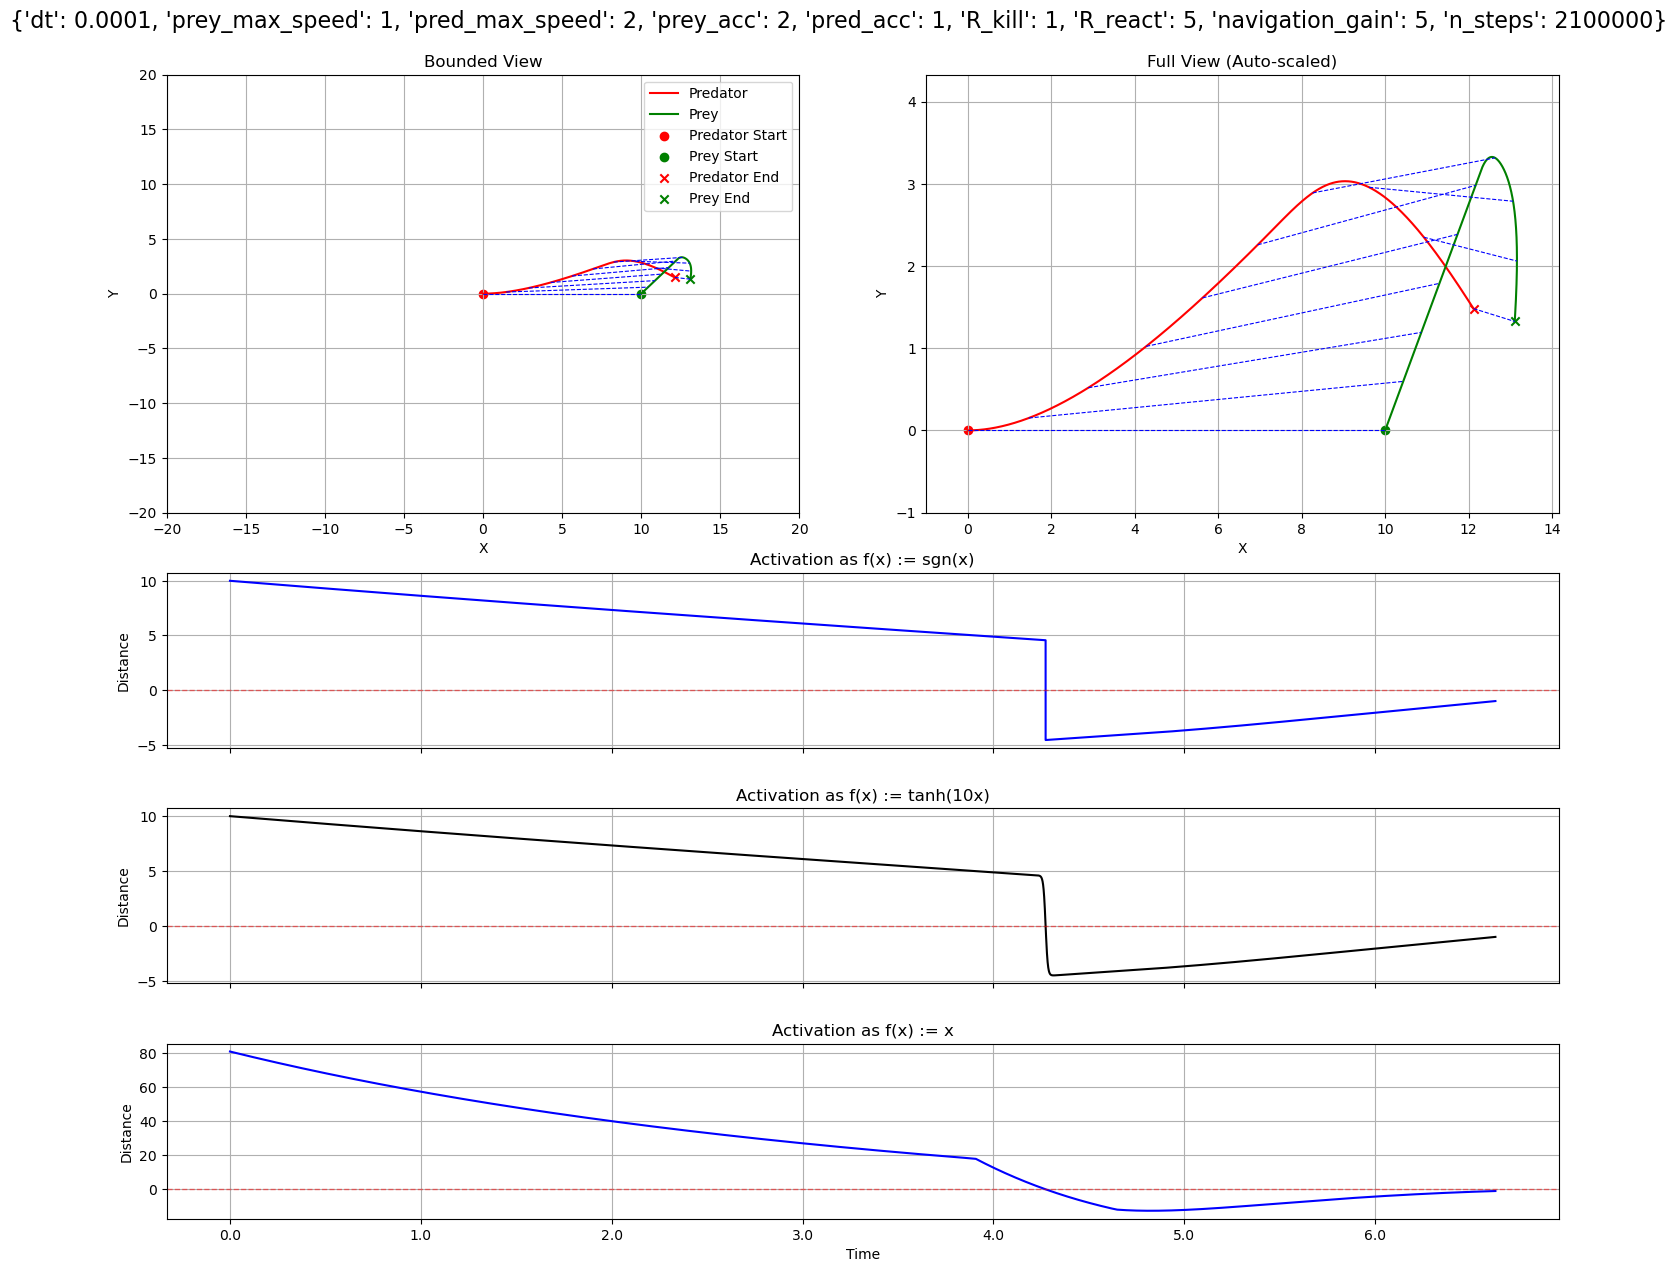

In [8]:
from utilities import plot_combined_analysis

sign = lambda state : signed_distance(state, activation = lambda x: np.sign(x))
tanh = lambda state : signed_distance(state, activation = lambda x: np.tanh(10*x))
id = lambda state : signed_distance(state, activation = lambda x: x)

params = {
    "dt": 0.0001,
    
    "prey_max_speed": 1,
    "pred_max_speed": 2, # >
    
    "prey_acc": 2, # >
    "pred_acc": 1,
    
    "R_kill": 1,
    "R_react": 5,

    "navigation_gain": 5,
}

time = 210
bearing = 36
params['n_steps'] = round(time / params['dt'])

state = get_trajectory(bearing, params['n_steps'], params['prey_max_speed'], params['pred_max_speed'])

state, length = simulate(state, params)
state = state[:length]

plot_combined_analysis(
    state,
    params=params,
    analysis_fns=[
        (sign, 'Activation as f(x) := sgn(x)', 'Distance'),
        (tanh, 'Activation as f(x) := tanh(10x)', 'Distance'),
        (id, 'Activation as f(x) := x', 'Distance'),
    ],
)

We can notice a clear tradeoff between the regularity of the 'Signed Distance Function' and its fidelity in representing both sign and distance, which depends on the activation function. In fact, smoother approximations of the _sign_ function can provide more regular signed distance functions for the trajectories, at the cost of deviating from the pure form of sign $\times$ norm.

We proceed by observing how initial conditions affect behaviour: we vary initial bearing, that is, the angle of the prey, while fixing the predator's initial conditions. We then plot for reference both scaled and normalised plots of $(x,y)$ trajectories, showing the relative positions between prey and predator using isochrone lines. To complete the picture, we show the evolution of some relevant metrics over the run.

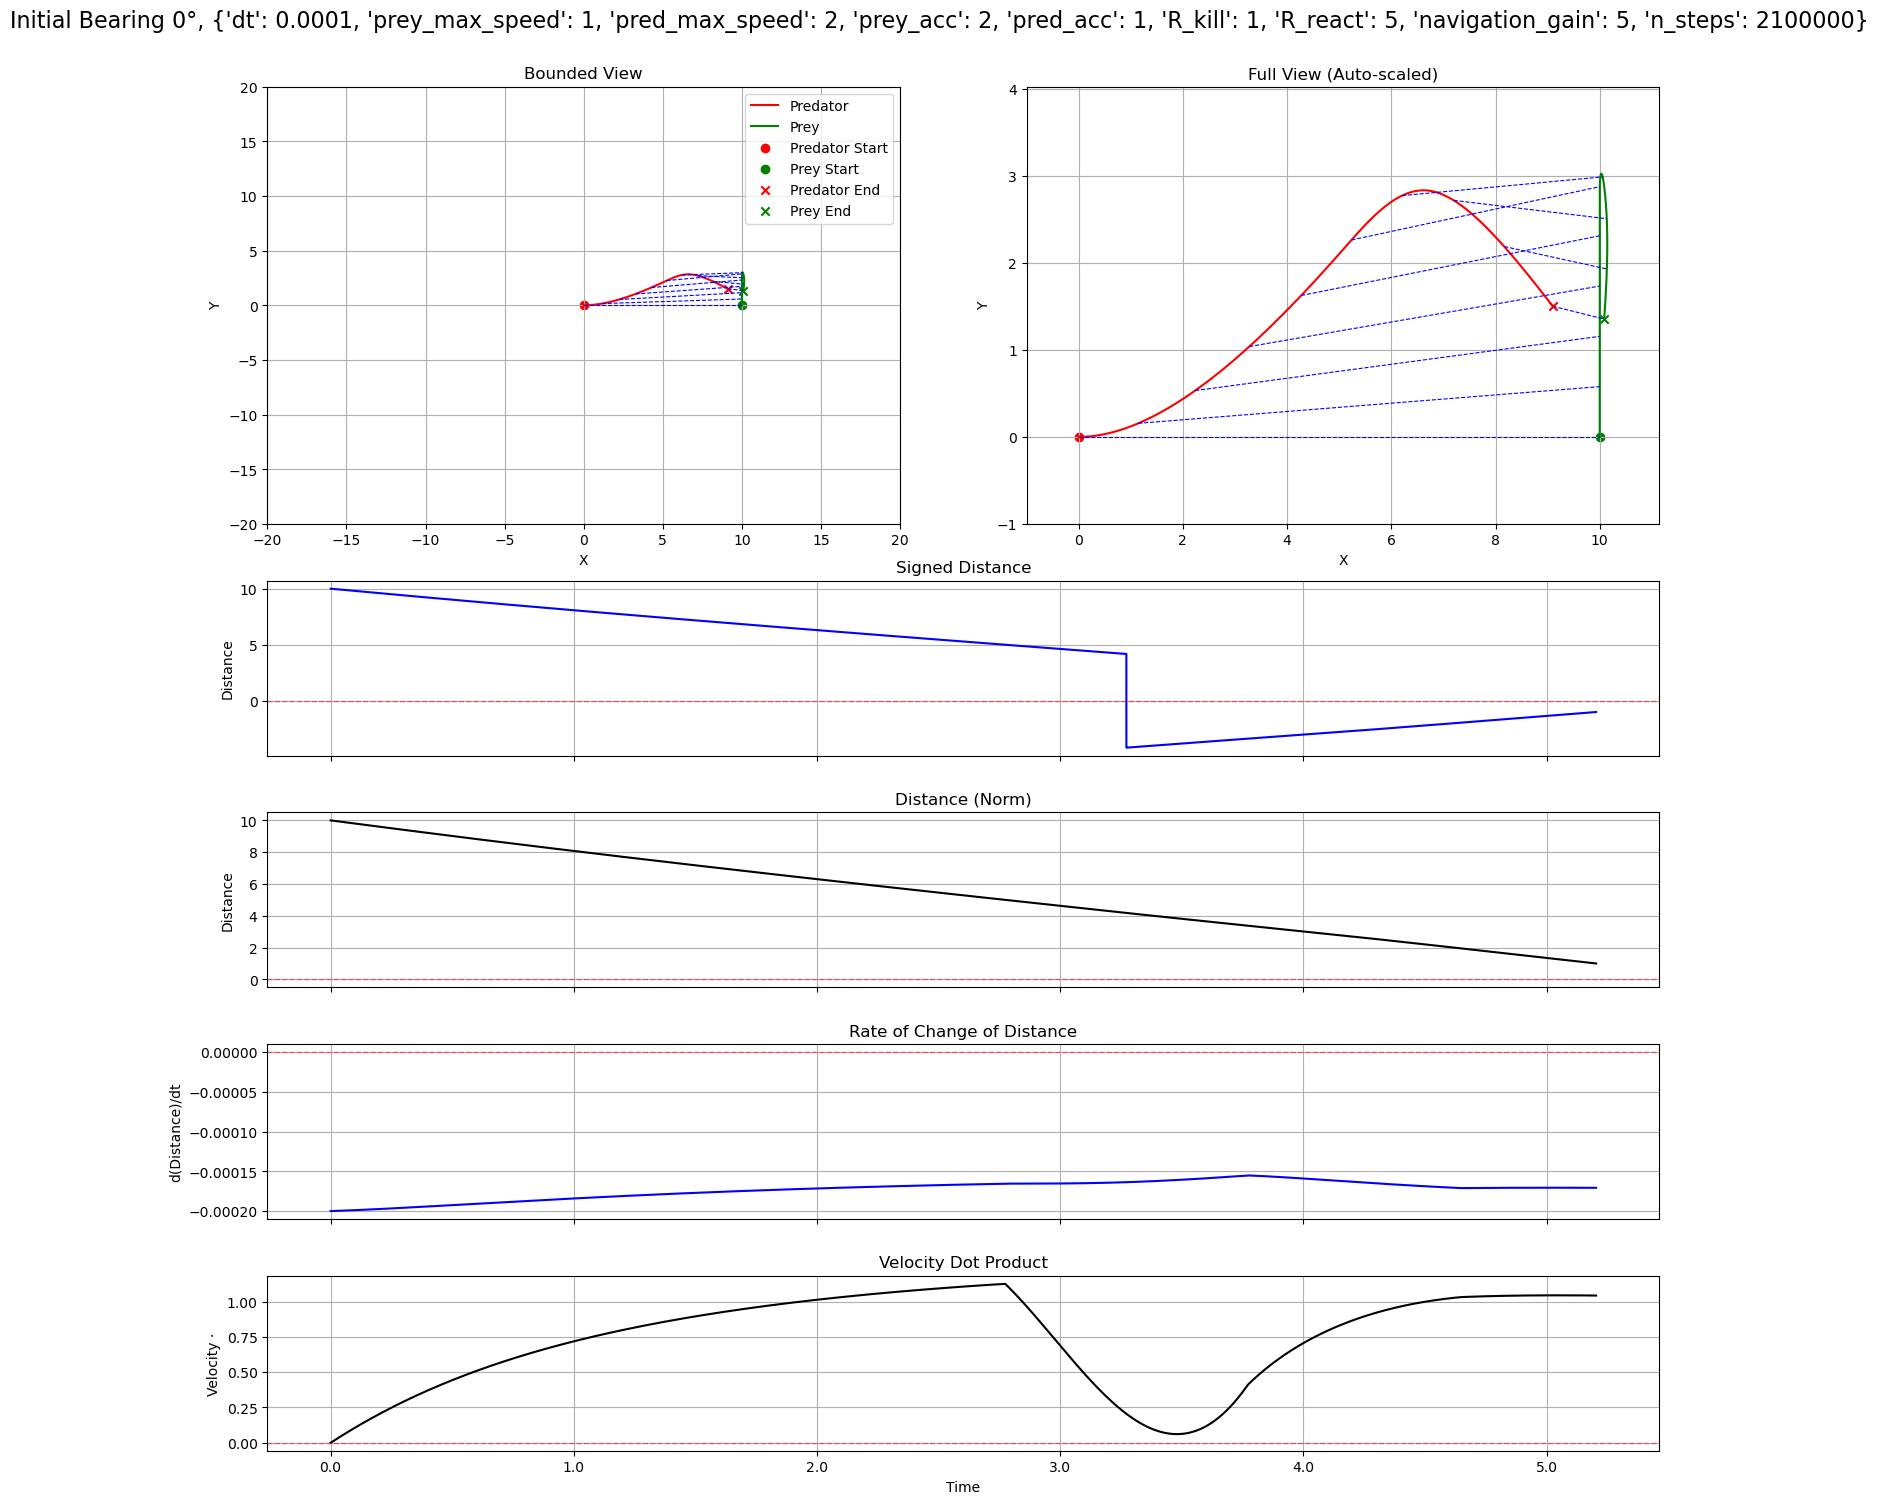

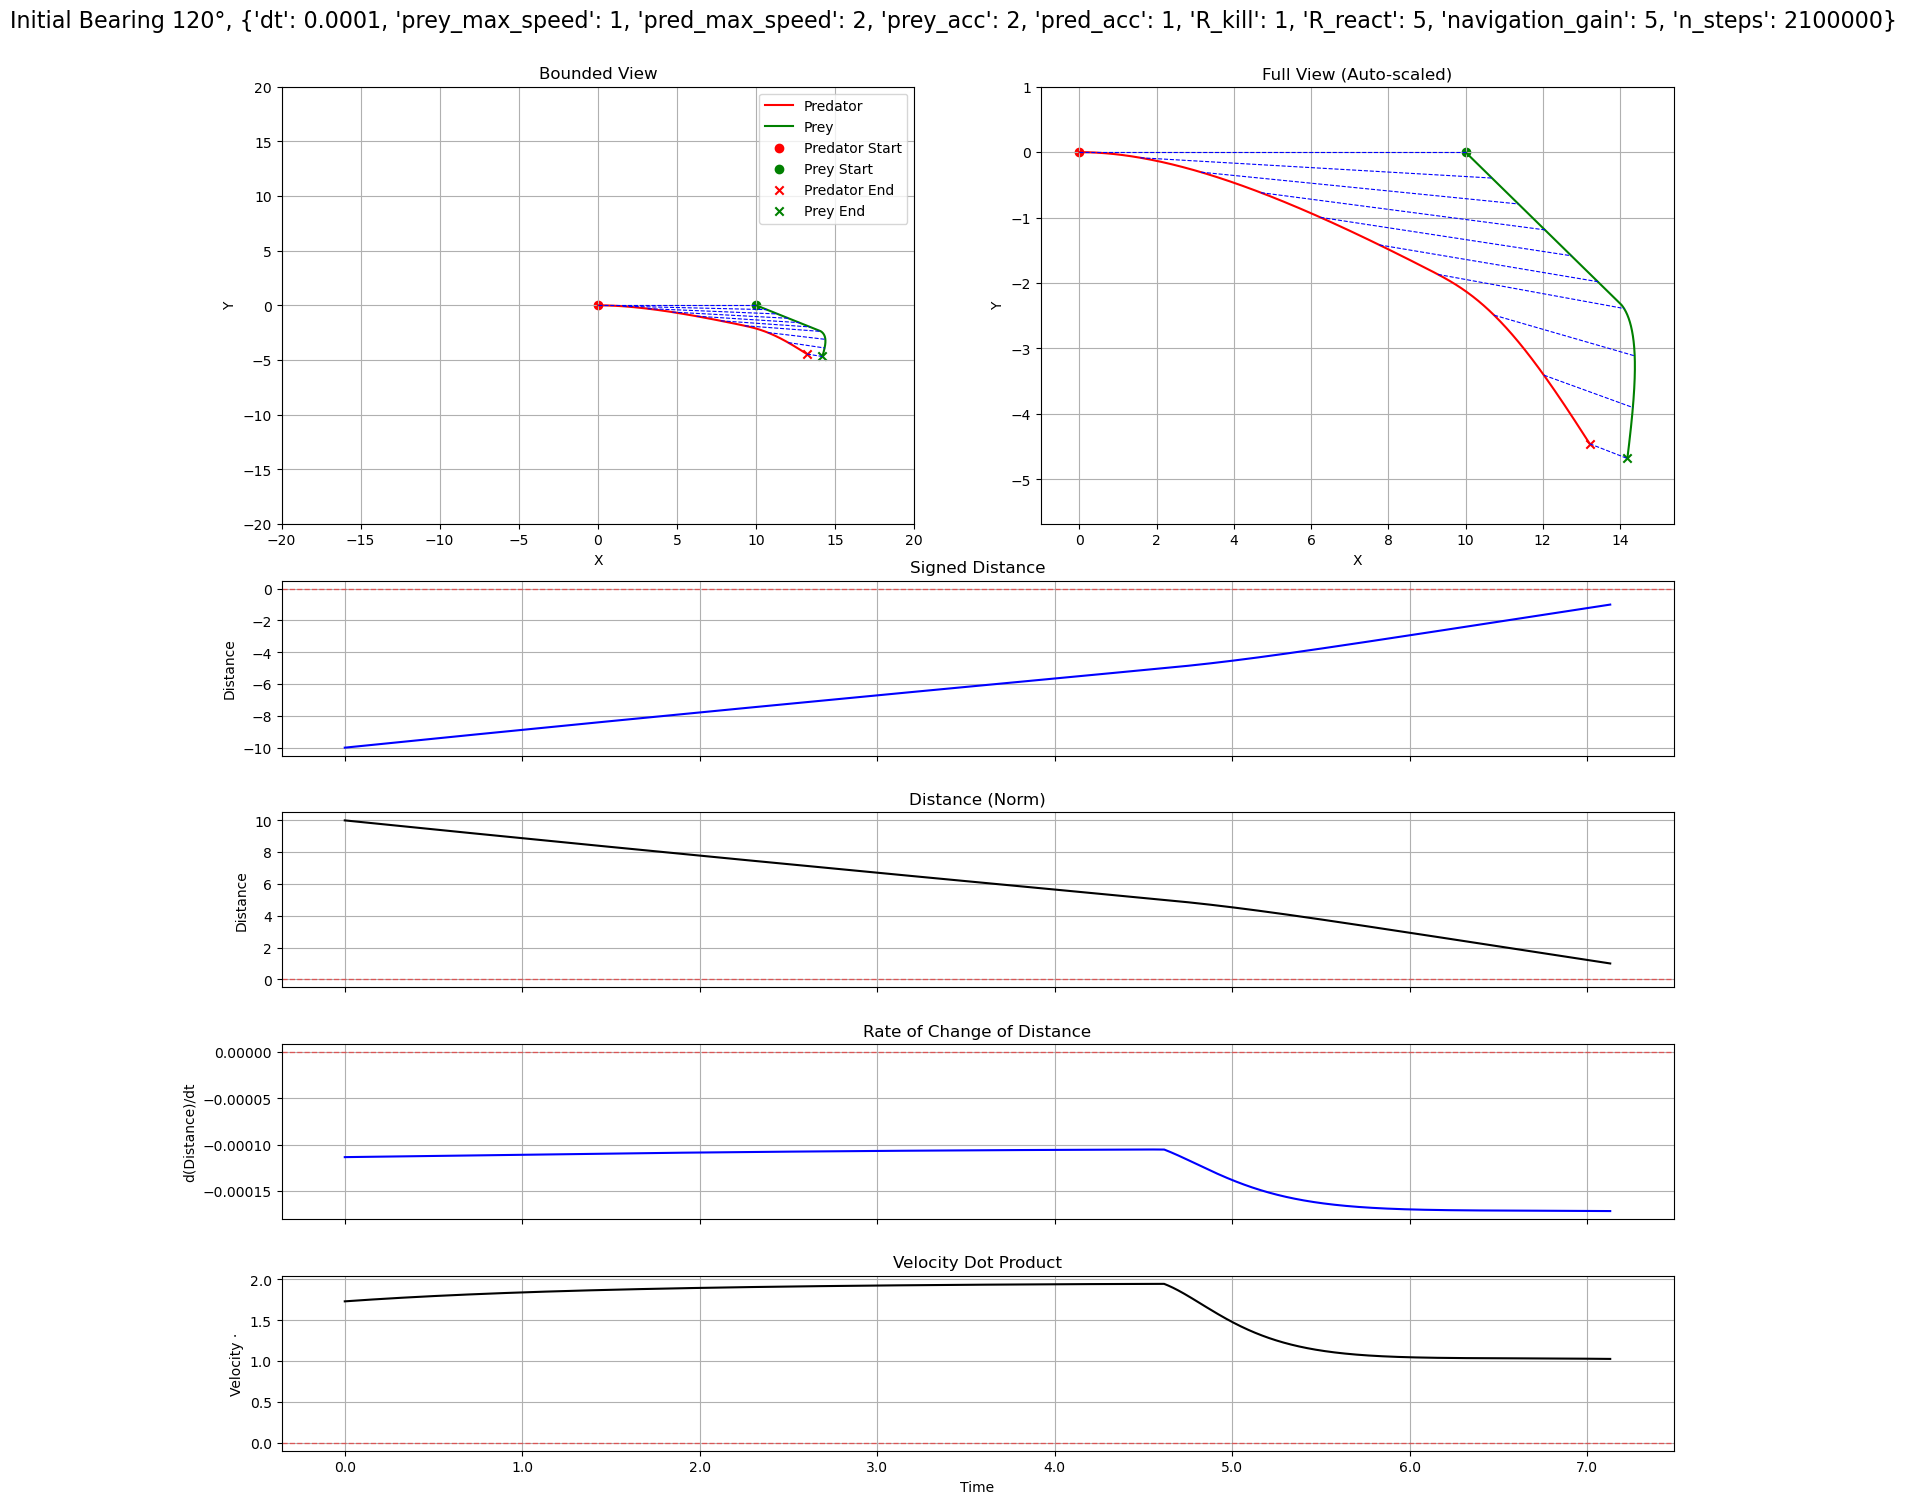

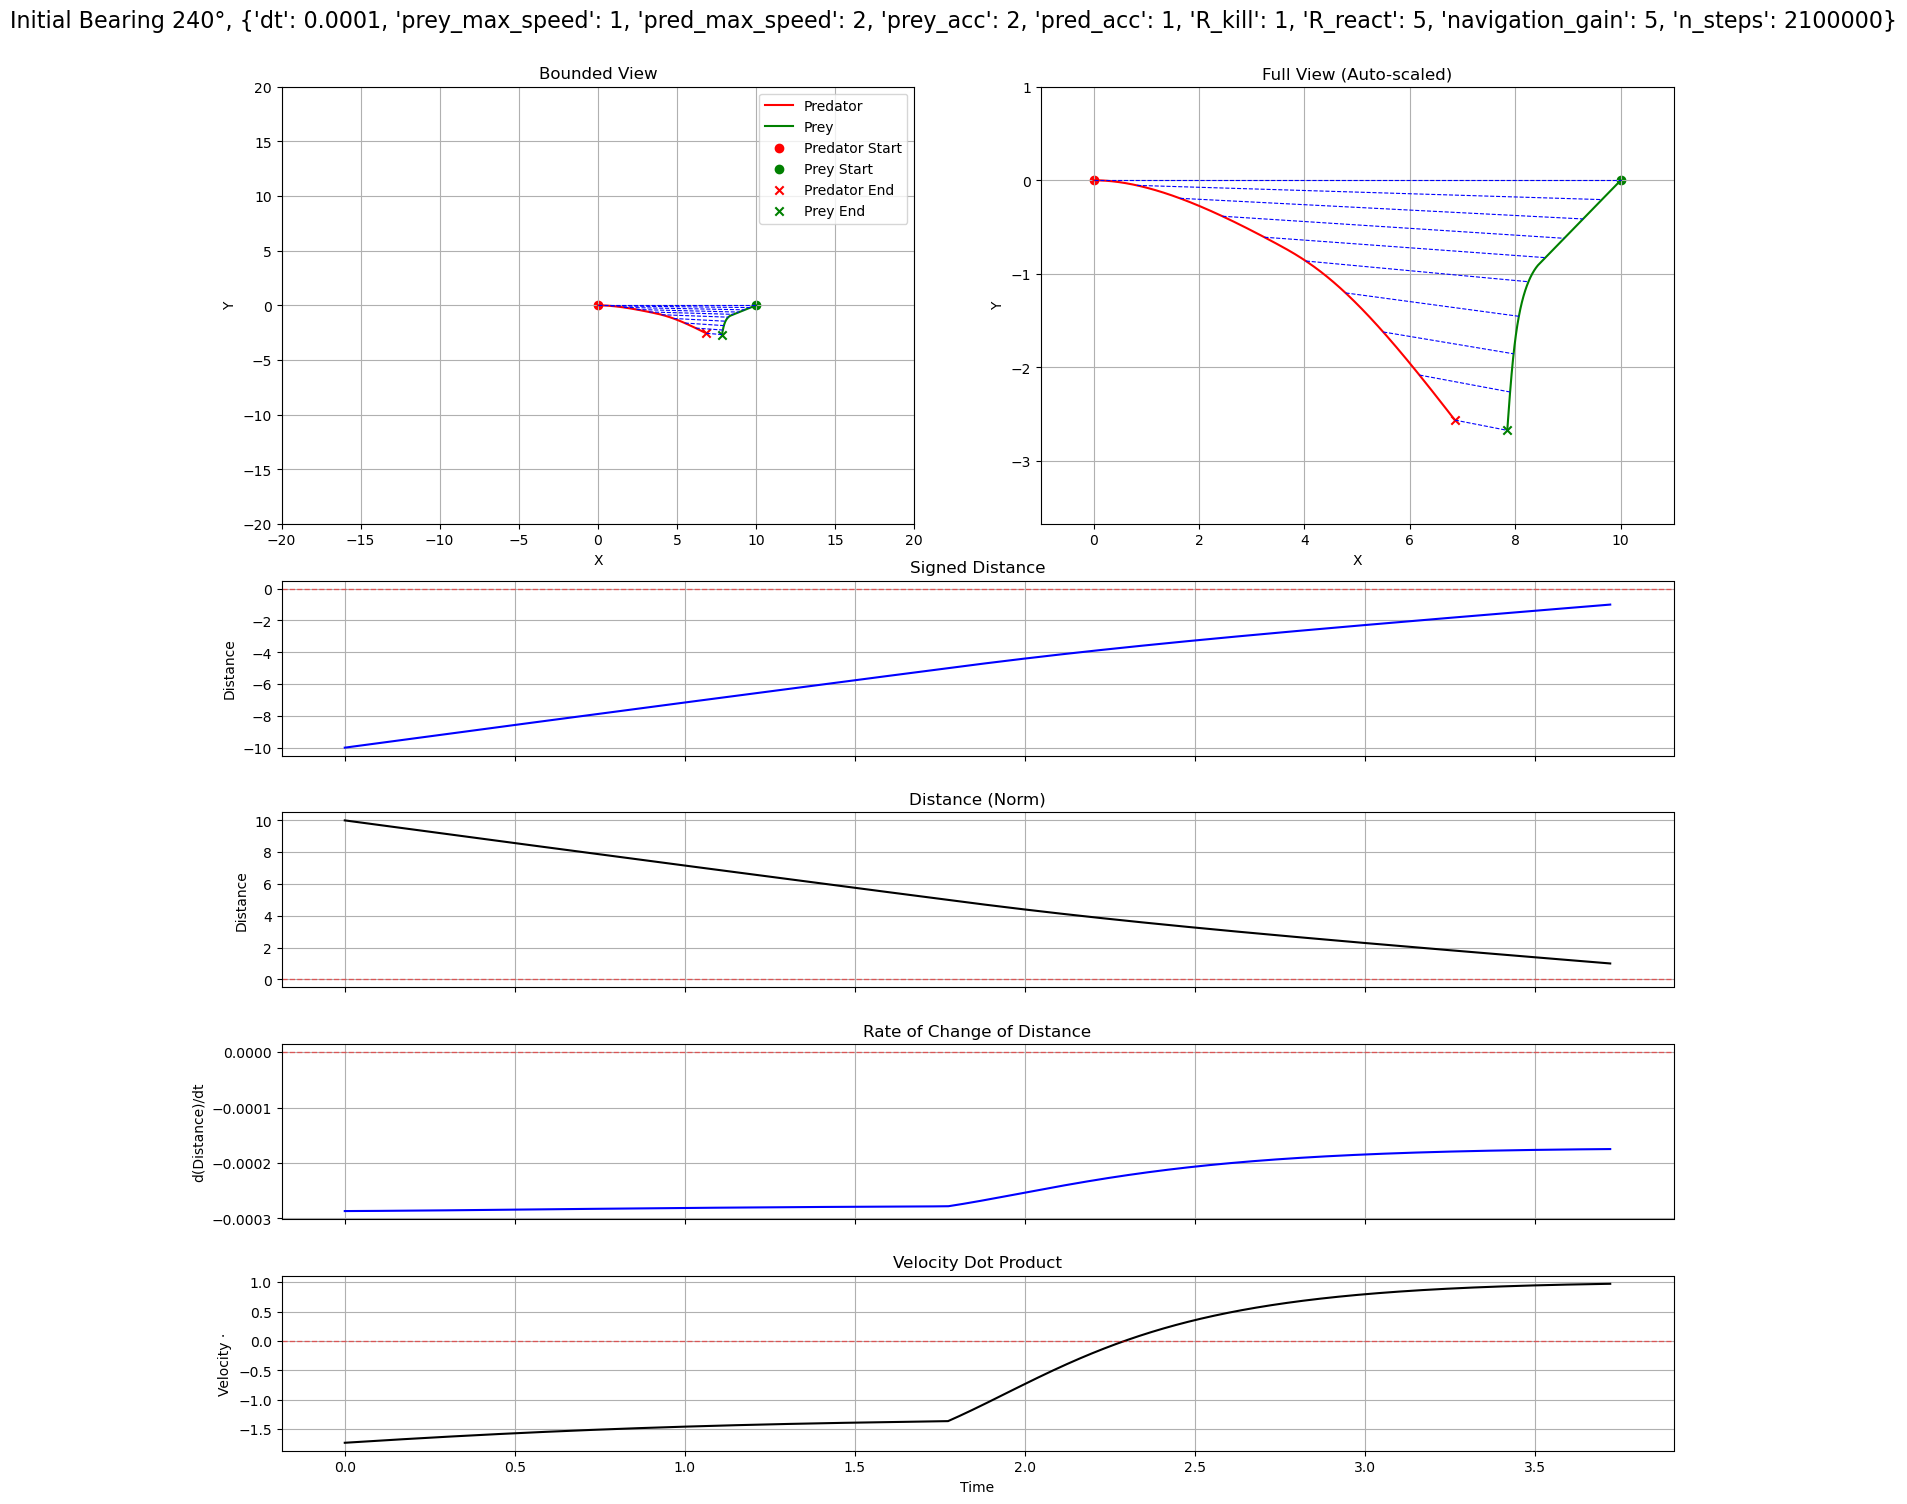

In [9]:
recordings = []
n = 3
distance = 210 # 

for i in range(n):
    bearing = 360/n*i
    params['n_steps'] = round(distance / params['dt'])
    
    state = get_trajectory(bearing, params['n_steps'], params['prey_max_speed'], params['pred_max_speed'])
    state, length = simulate(state, params)
    state = state[:length]
    recordings += [(params, state)]
    
    plot_combined_analysis(
        state,
        params=params,
        analysis_fns=[
            (signed_distance, 'Signed Distance', 'Distance'),
            (positive_distance, 'Distance (Norm)', 'Distance'),
            (distance_derivative, 'Rate of Change of Distance', 'd(Distance)/dt'),
            (velocity_dot_product, 'Velocity Dot Product', 'Velocity ⋅')
        ],
        title = f'Initial Bearing {bearing:.0f}°, {params}'
    )

The presence of waves and a natural frequency suggests the need to use more advanced methods to understand the behavior, namely the Cosine Transform: this technique consists in decomposing a function into the cosine waves, which is the natural method to identify the "dominant" frequencies within a periodic function.

In [10]:
@njit
def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

@njit
def hamming_window(N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

To characterise the behaviour of the metrics in the trajectories, we use the Discrete Cosine Transform, which has a time complexity of order O(N*log(N)). Moreover, as only a part of the wave is calculated, the cutoff is bound to be imprecise, leading to noise in the transformation. For this reason we use a window function to cutoff the signal, obtaining two possible transforms.

In [11]:
@njit
def twiddle_factors(N):
    """Pre-compute twiddle factors for FFT"""
    factors = np.zeros(N//2, dtype=np.complex128)
    for k in range(N//2):
        angle = -2.0 * np.pi * k / N
        factors[k] = np.cos(angle) + 1j * np.sin(angle)
    return factors

@njit
def fft_radix2(x):
    """
    Numba-compatible FFT implementation using Radix-2 algorithm
    Only works for power-of-2 length inputs
    """
    N = len(x)
    
    # Base case for recursion
    if N == 1:
        return x
    
    # Check if N is a power of 2
    if N & (N-1) != 0:
        raise ValueError("Input length must be a power of 2")
    
    # Split into even and odd indices
    even = fft_radix2(x[0:N:2])
    odd = fft_radix2(x[1:N:2])
    
    # Combine results
    result = np.zeros(N, dtype=np.complex128)
    factors = twiddle_factors(N)
    
    for k in range(N//2):
        twiddle = factors[k] * odd[k]
        result[k] = even[k] + twiddle
        result[k + N//2] = even[k] - twiddle
    
    return result

@njit
def dct_via_fft(x):
    """
    DCT implementation using custom FFT function
    Only works for power-of-2 length inputs
    """
    N = len(x)
    
    # Prepare the input for FFT-based DCT
    y = np.zeros(2*N, dtype=np.complex128)
    for n in range(N):
        y[n] = x[n]
        y[2*N-1-n] = x[n]
    
    # Compute FFT
    Y = fft_radix2(y)
    
    # Apply scaling
    result = np.zeros(N)
    scale = np.sqrt(1.0 / (2.0 * N))
    for k in range(N):
        # Extract real part for DCT result
        result[k] = Y[k].real * scale
    
    # Additional scaling for DC component
    result[0] *= 1.0 / np.sqrt(2.0)
    
    return result

We plot the log-log Discrete Cosine Transform to study the results: decomposing the signed distance for the previous three trajectories, we notice that the _Hamming Window_ performs better, producing narrower peakes, which is more aligned with the "Dirac Comb" shape predicted theoretically. 

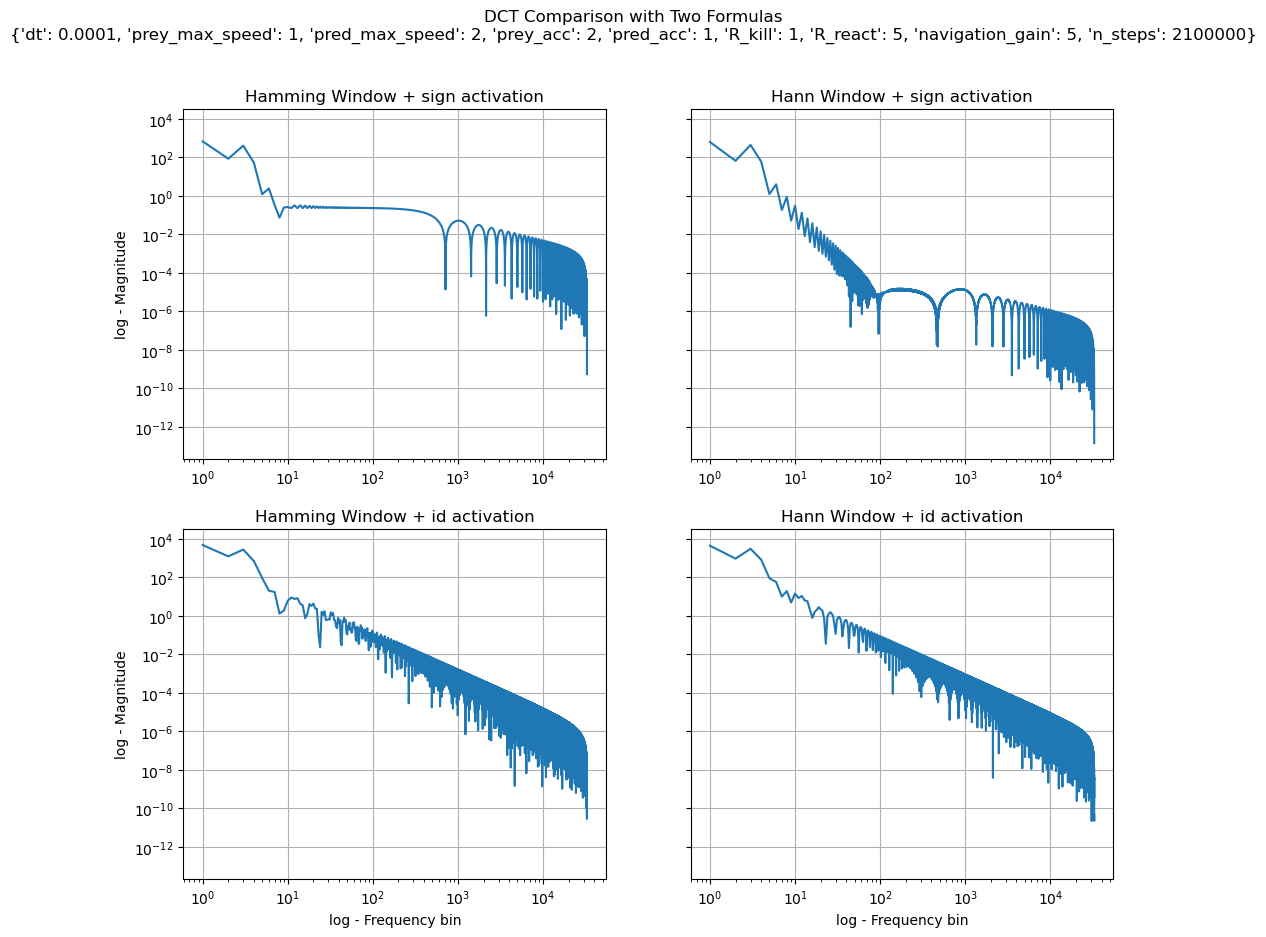

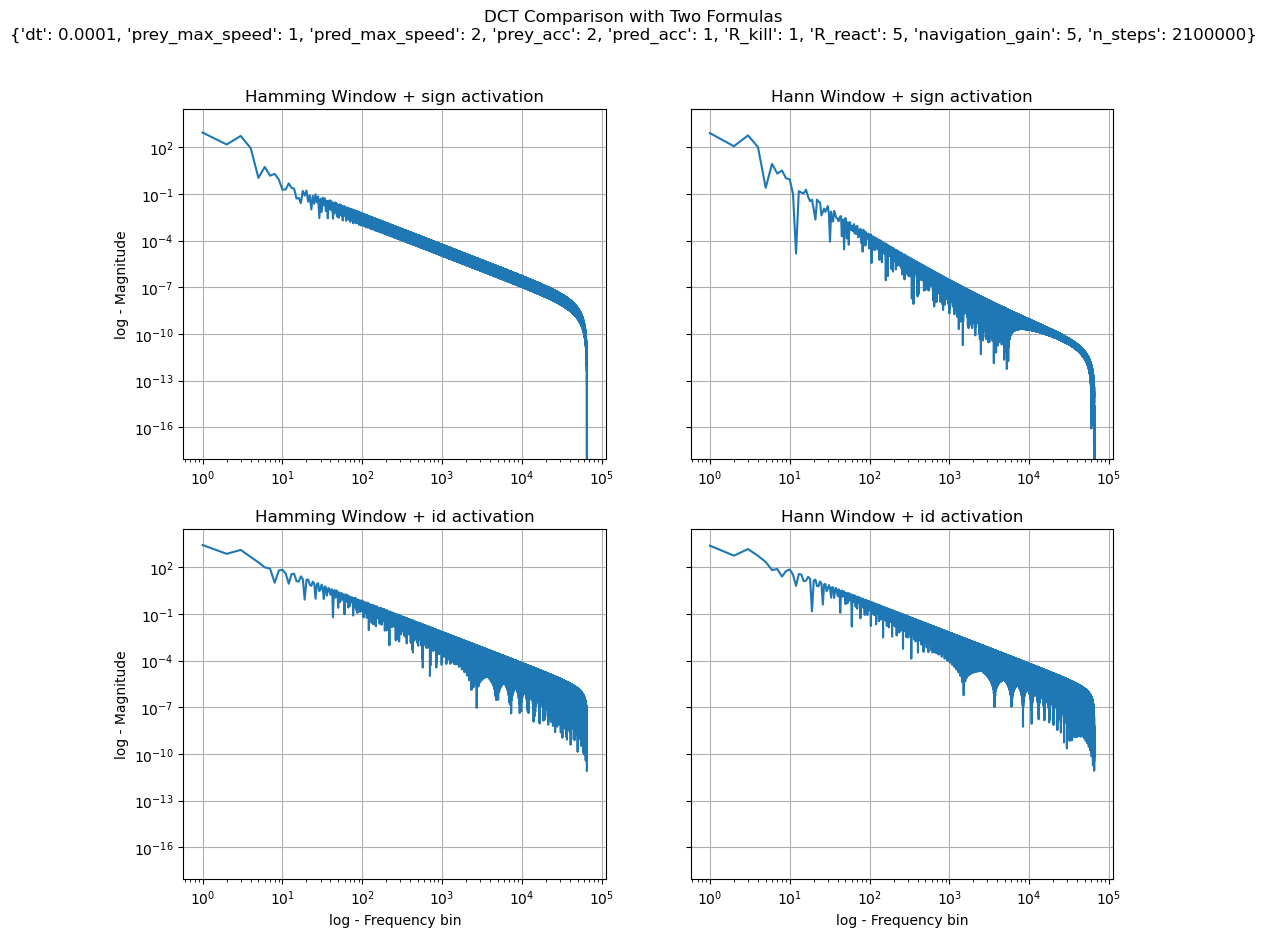

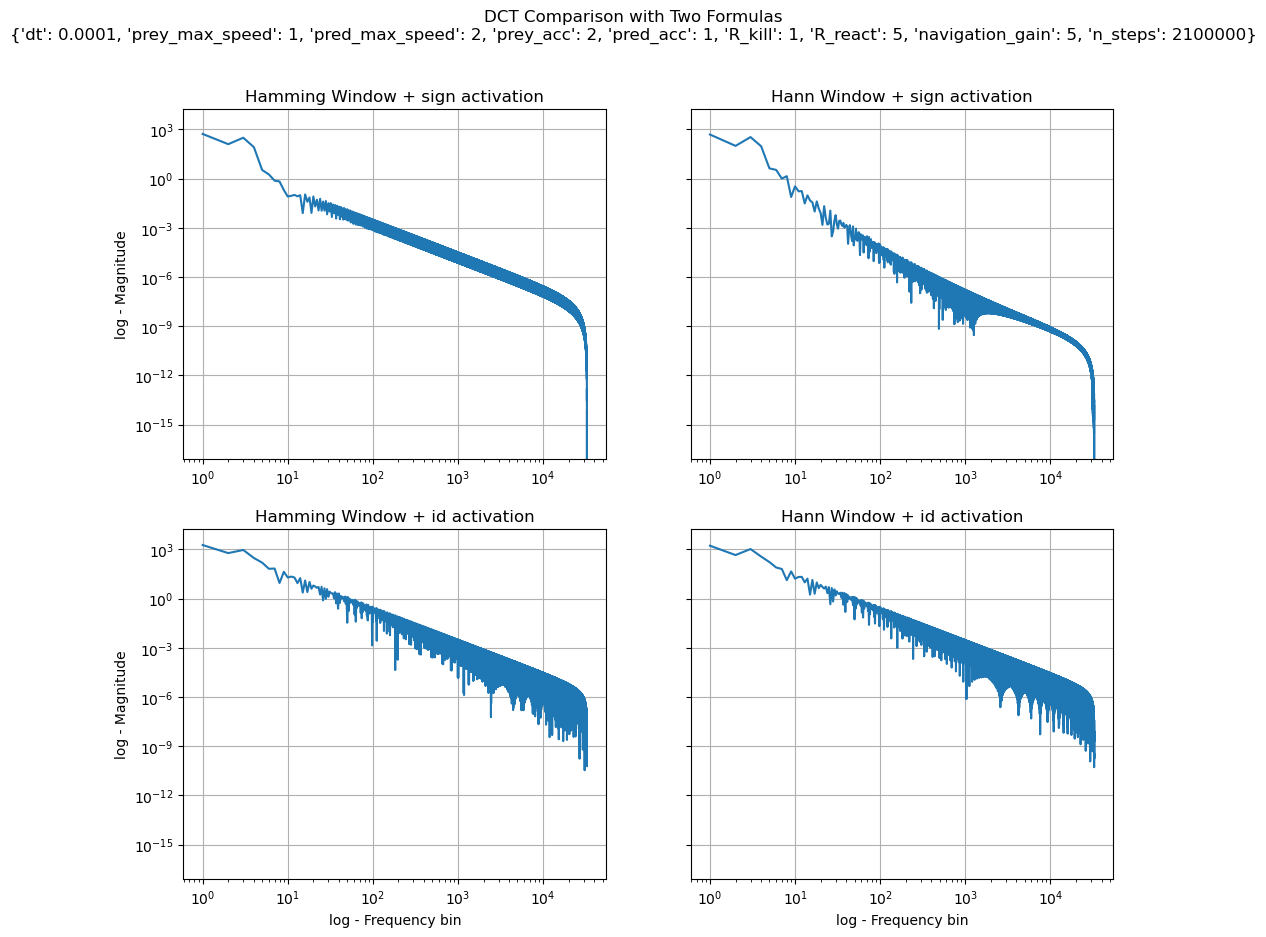

In [12]:
def dct(state, formula=signed_distance, window=hamming_window):
    """
    Computes the Discrete Cosine Transform (DCT) of a signal after applying a 
    windowing function and truncating the signal to the nearest power of two.

    Parameters:
    state (numpy.ndarray): Input signal array.

    Returns:
    numpy.ndarray: DCT of the windowed and truncated signal.
    """
    length = len(state)
    highest_two_power = 2**(length.bit_length() - 1)  # Get nearest power of two
    wave = formula(state)[:highest_two_power]
    return dct_via_fft(wave * window(len(wave)))

def compare_dct_windows(state, params: dict):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

    formulas = [(signed_distance, "sign activation"), (id, "id activation")]

    for row, (formula_fn, formula_name) in enumerate(formulas):
        for col, (window_fn, window_name) in enumerate(zip([hamming_window, hann_window], ['Hamming', 'Hann'])):
            result = dct(state, formula=formula_fn, window=window_fn)
            y = np.abs(result)
            x = np.arange(1, len(y) + 1)

            ax = axs[row, col]
            ax.plot(x, y, label=f'{window_name} window')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True)
            ax.set_title(f'{window_name} Window + {formula_name}')

            if row == 1:
                ax.set_xlabel('log - Frequency bin')
            if col == 0:
                ax.set_ylabel('log - Magnitude')

    fig.suptitle(f'DCT Comparison with Two Formulas\n{params}')
    plt.show()

for params, state in recordings:
    compare_dct_windows(state, params)

In the first plot, the 'thumb' shapes of the cosine decomposition, may be informally understood by observing the behaviour of the similar function, $t(x) := \frac{2}{1+x^4}$, taken as a single peak in the decomposition. Evaluating the antitransform and observing the positive $x>0$ values, one recognises the behaviour and general shape of a damped oscillator, which is related to the behaviour of the first trajectory.

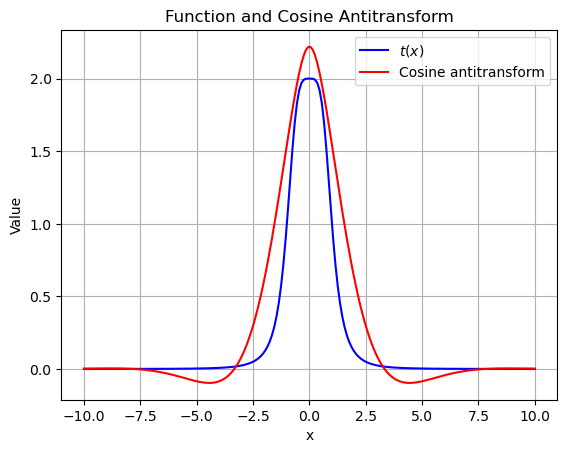

In [13]:
from scipy.integrate import quad

def t(x):
    return (1 - x**4) / (1 + x**4) + 1

def cosine_antitransform(k):
    integrand = lambda x: t(x) * np.cos(k * x)
    val, _ = quad(integrand, 0, 10)
    return val

x_vals = np.linspace(-10, 10, 200)
t_vals = t(x_vals)
cos_vals = np.array([cosine_antitransform(k) for k in x_vals])

plt.plot(x_vals, t_vals, label=r'$t(x)$', color='blue')
plt.plot(x_vals, cos_vals, label='Cosine antitransform', color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Function and Cosine Antitransform')
plt.grid(True)
plt.show()

By observing the plots, we note three key characterizations of the waves, given their Cosine Transforms:
- <u>Mean Distance</u>: the y-axis intercept shows the mean value of the function.
- <u>Peak</u>: the Cosine Transform Identifies the key natural frequency of the way
- <u>Noisy tail</u>: the higher end of the transform are particularly noisy, especially for waves with jumps.

We also observe the presence of noise, which may be attributed to the irregularities of the signed distance: in fact, when the identity is used as activation, the noise is reduced and the decay rate - the slope of the right tail - is stronger. It is clear that more regular waves produce sharper results. This is also apparent in the following plot, which display the cosine transform of the distance $d(x,y) := ||x(t)-y(t)||$, a more regular wave.

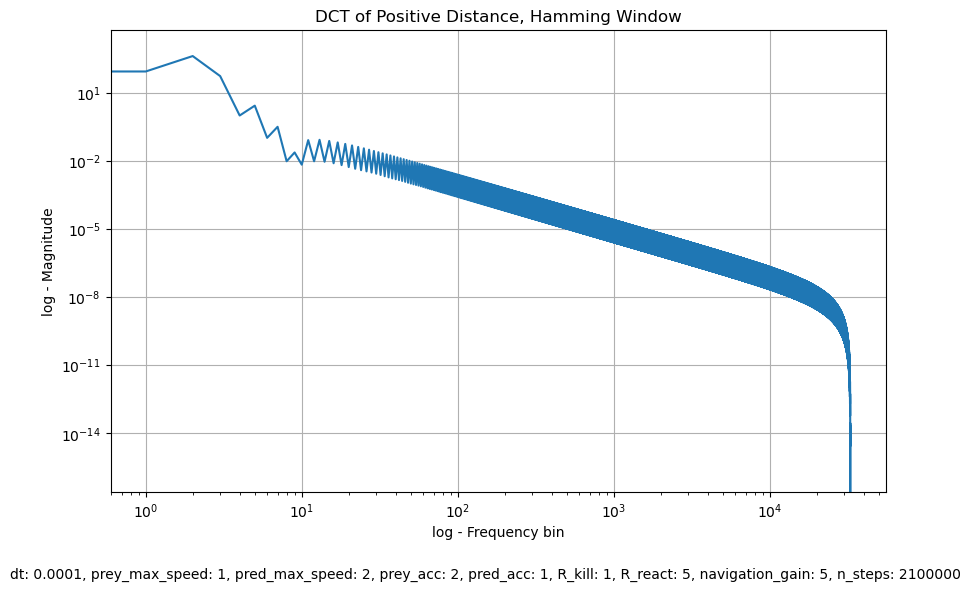

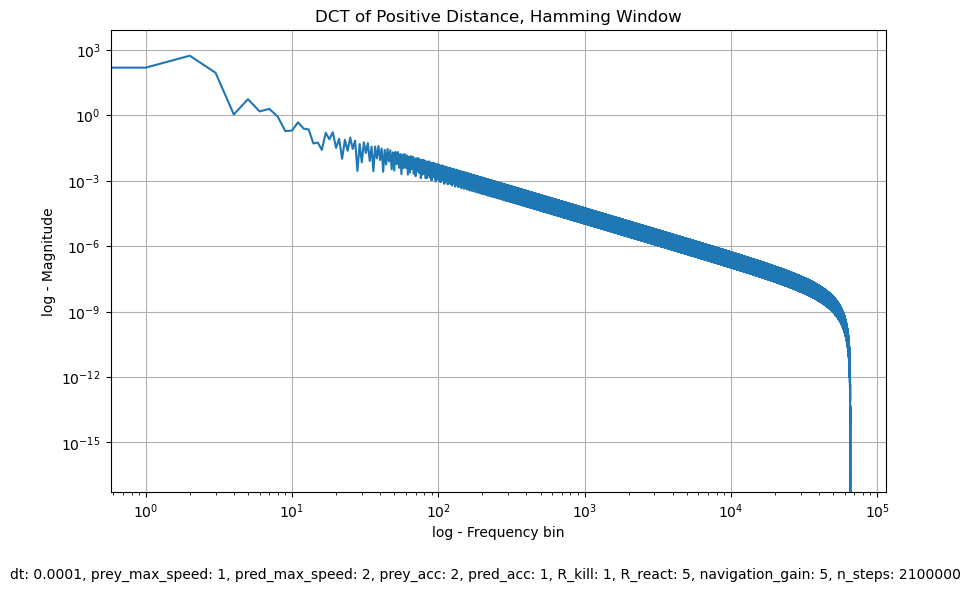

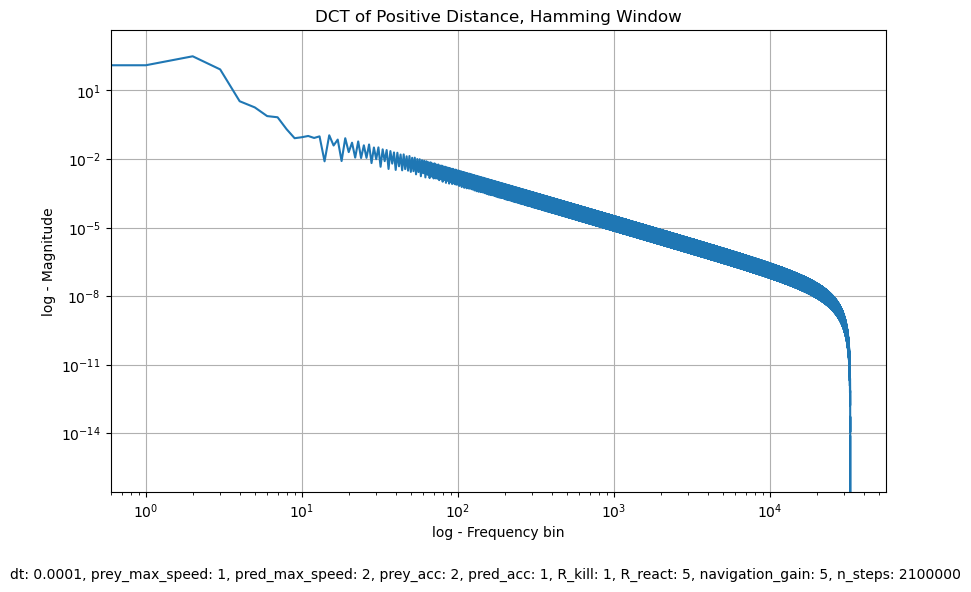

In [14]:
def plot_dct(dct_result, params: dict, title:str=""):
    if not title:
        title = f'DCT of State'

    fig = plt.figure(figsize=(10, 6))
    plt.plot(np.abs(dct_result), label='DCT Magnitude')
    plt.title(title)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('log - Frequency bin')
    plt.ylabel('log - Magnitude')
    plt.grid(True)

    params_text = ', '.join(f'{k}: {v}' for k, v in params.items())
    fig.text(0.5, -0.04, params_text, ha='center', va='bottom', fontsize=10, wrap=True)

    plt.show()

for params, state in recordings:
    dct_result = dct(state, formula=positive_distance, window=hamming_window)
    plot_dct(dct_result, params, title=f'DCT of Positive Distance, Hamming Window')

On a final note, extracting the 'pure' frequency of the wave is easier by only considering the distance (ie. the euclidean norm) in the space, at the cost of losing the qualitative aspect of signed distance

# Phase Space Plots
We now consider ensemble plots of the prey-predator dynamics, to understand how acceleration and speed relate to pursuit-evasion effectiveness. To do this, we fix the starting conditions and vary continuously acceleration in the pray and maximal speed of the predator, while fixing all the other attributes. 

Although the following description does not paint a complete picture of the parameter space, studying a subset of their possible values highlights both an effective methodology and an examples of behaviours that may emerge. Moreover, the same tools shown in this investigation can be applied to evaluate specific parameter neighbourhoods in other values of the simulation.

In [15]:
def get_phase_titles():
    return [
        "chase duration",
        "mean distance",
        "mean signed dist",
        "std signed distance",
        "mean velocity dot product",
        "final velocity dot product",
        "mean distance derivative",
        "std distance derivative",
        "final speed difference",
        "final acceleration difference"
    ]

@njit
def compute_statistics(state, dt):
    T = state.shape[0]*dt

    distances = positive_distance(state)
    signed_distances = sign_distance(state)
    dist_deriv = distance_derivative(state)
    vel_dot = velocity_dot_product(state)

    # Distance stats
    mean_dist = np.mean(distances)

    # Signed distance stats
    mean_signed = np.mean(signed_distances)
    std_signed = np.std(signed_distances)

    # Distance derivative stats
    mean_d_dist = np.mean(dist_deriv)
    std_d_dist = np.std(dist_deriv)

    # Velocity dot product
    mean_vel_dot = np.mean(vel_dot)
    final_vel_dot = vel_dot[-1]

    # Final speed and acceleration
    final_speed_pred = norm_list(state[-1, 0, 1, np.newaxis])[0]
    final_speed_prey = norm_list(state[-1, 1, 1, np.newaxis])[0]
    final_acc_pred = norm_list(state[-2, 0, 2, np.newaxis])[0]
    final_acc_prey = norm_list(state[-2, 1, 2, np.newaxis])[0]

    final_speed_diff = final_speed_prey - final_speed_pred
    final_acc_diff = final_acc_prey - final_acc_pred

    return (
        T,
        mean_dist,
        mean_signed,
        std_d_dist,
        mean_vel_dot,
        std_signed,
        mean_d_dist,
        final_vel_dot,
        final_speed_diff,
        final_acc_diff
    )

For matters of computational and memory efficiency, we proceed by approximate each trajectory, before evaluating key metrics, which we display using heatmaps.

In [16]:
from numba import prange

@njit
def positive_distance(state):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]
    return norm_list(distance)

@njit
def simulate_task(i, j, bearing, dt, n_steps, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, navigation_gain):
    pred_max_speed = v_range[i]
    prey_acc = a_range[j]
    
    state = get_trajectory(bearing, n_steps, prey_max_speed, pred_max_speed)
    if r_kill < 0:
        _, length = simul_nokill(state, dt, r_react, pred_acc, prey_acc, pred_max_speed, prey_max_speed, navigation_gain)
    else:
        _, length = simul(state, dt, r_kill, r_react, pred_acc, prey_acc, pred_max_speed, prey_max_speed, navigation_gain)
    
    return compute_statistics(state[:length], dt)

@njit(parallel=True)
def simulate_grid_parallel(bearing, dt, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, max_time, navigation_gain):
    n_v = len(v_range)
    n_a = len(a_range)
    n_steps = round(max_time / dt)
    results = np.zeros((n_v, n_a, 10), dtype=np.float64)

    for i in prange(n_v):
        for j in prange(n_a):
            stats = simulate_task(i, j, bearing, dt, n_steps, pred_acc, prey_max_speed, r_kill, r_react, v_range, a_range, navigation_gain)
            results[i, j, :] = np.array(stats, dtype=np.float64)
        
    return results

We use the following conditions to define the runs: we use a step size of 100 to interpolate a square range of $(v^\text{max}_y, a_x)$ values, where each combination corresponds to a run. We then plot different metrics for each run.

$\left\{
\begin{aligned}
&n_{\text{ticks}} = 100,\quad v_y \in [1, 10],\quad a_x \in [1, 10],\quad \Delta t = 0.0001,\quad t_{\text{max}} = 20,\quad n = 5 \\
&a^{\text{max}}_y = 1,\quad R_{\text{kill}} = 1 \\
&v^{\text{max}}_x = 1,\quad R_{\text{react}} = 5
\end{aligned}
\right.$

For practical reasons, we include the $t_{\text{max}}$ term, which bounds the maximum duration of a single trajectory, to discard trajectories which may never converge.

In [17]:
n = 100
# vary predator velocity
v_range=np.arange(1, 10, 9/n, dtype=np.float64)
# vary prey acceleration
a_range=np.arange(1, 10, 9/n, dtype=np.float64)

parameters = {}
parameters['bearing'] = 0
parameters['dt'] = 0.0001
parameters['pred_acc'] = 1
parameters['R_kill'] = 1
parameters['R_react'] = 5
parameters['prey_max_speed'] = 1
parameters['max_time'] = 20
parameters['navigation_gain'] = 2


result_grid = simulate_grid_parallel(
                bearing=parameters['bearing'],
                dt=parameters['dt'],
                pred_acc=parameters['pred_acc'],
                prey_max_speed=parameters['prey_max_speed'],
                r_kill=parameters['R_kill'],
                r_react=parameters['R_react'],
                v_range=v_range,
                a_range=a_range,
                max_time=parameters['max_time'],
                navigation_gain=parameters['navigation_gain']
            )

print(result_grid.shape)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(100, 100, 10)


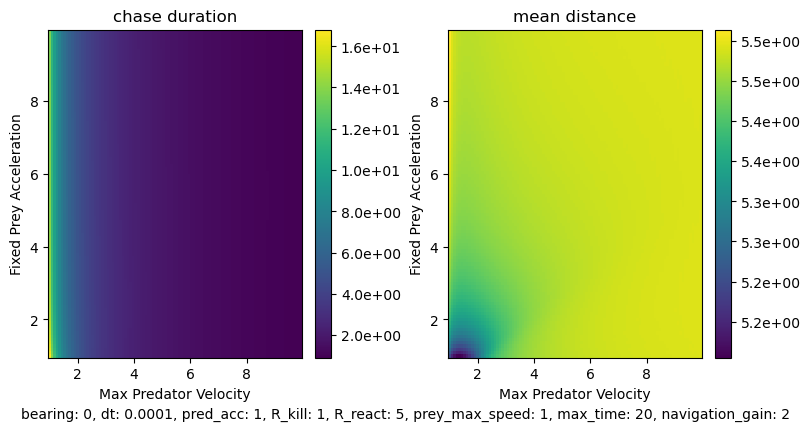

In [18]:
def plot_3d_array_slices(data: np.ndarray, params: dict, titles: list, ncols:int, xtitle: str='Fixed Prey Acceleration', ytitle:str='Max Predator Velocity', x=None, y=None):
    """
    Plot slices of a (N, M, L) array as NxM images for each L, arranged in a 4x4 grid.
    """
    if x is None:
        x = np.arange(data.shape[0])
    if y is None:
        y = np.arange(data.shape[1])

    X, Y = np.meshgrid(y, x)

    n_slices = data.shape[2]
    nrows = int(np.ceil(n_slices / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

    params_text = ', '.join(f'{k}: {v}' for k, v in params.items())
    fig.text(0.5, -0.04, params_text, ha='center', va='bottom', fontsize=10, wrap=True)

    for i in range(n_slices):
        row, col = divmod(i, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        pcm = ax.pcolormesh(Y, X, data[:, :, i], shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, format=ticker.FuncFormatter(lambda x, _: f'{x:.1e}'))  # scientific notation
        ax.set_title(f'{titles[i]}')
        ax.set_xlabel(ytitle)
        ax.set_ylabel(xtitle)

    # Hide any unused subplots
    for j in range(n_slices, nrows * ncols):
        row, col = divmod(j, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        ax.axis('off')

    plt.show()
    
        
plot_3d_array_slices(result_grid[:, :, :2], parameters, 
                     titles = get_phase_titles()[:2], 
                     x=v_range, 
                     y=a_range,
                     ncols=2)

As a preliminary step, we observe chase duration and confirm that, as expected, reducing the predator's `max velocity` leads to longer chases, up to never catching the prey. This is clear from the scale, which achieves the maximum possible value. On the other hand, `predator velocity` values greater than $v_x^{\text{max}}=2$ seem to induce a shift in behaviour, with predators catching up in approximately in time $2.5 < t_{\text{max}} = 20$.

In an inverse way, average distance is uniform for $v_x^{\text{max}}>2$. We finally observe that similarly matched prey and predator, with both acceleration and speed low and equal, tend to remain close over the chase, which is clear from the lower-left corner in the mean-distance graph.

In few words, chases are short and successful for all prey accelerations, assuming the predator has high enough speed.

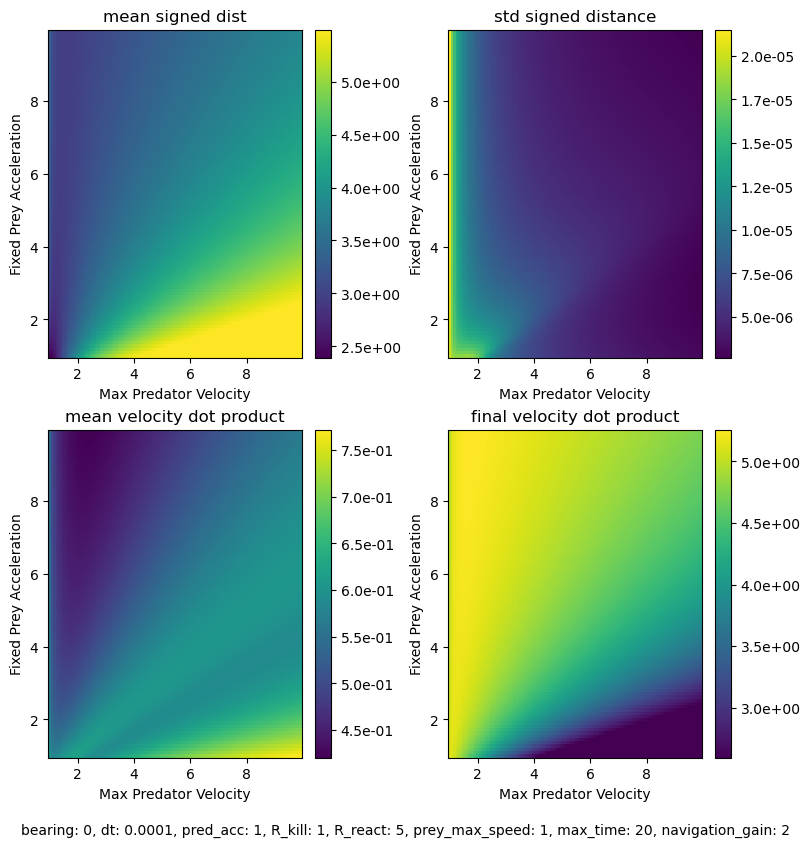

In [19]:
plot_3d_array_slices(result_grid[:, :, 2:6], parameters, 
                     titles = get_phase_titles()[2:6],
                     x=v_range, 
                     y=a_range,
                     ncols=2)

Mean distance and the dot product of the velocities highlight another qualitative difference in behaviour: for approximately $a^{\text{max}}_x > 0.5\cdot v^{\text{max}}_y - 1$, we observe both higher average alignment between the velocities and a lower final alignment. This behaviour also corresponds to a higher average signed distance value. In these runs, the predator catches up to the pray from one side, but intercepts it at a sharper angle of attack. Interestingly, the opposite effect happens when the proportions between $a^{\text{max}}_x > 0.5\cdot v^{\text{max}}_y - 1$ are reflected, with lower mean alignment over the chase but higher alignment at the end, highlighting that the predator chases the pray from afar, converging to it near the end. Clearly, depending on the relation between predator velocity and prey acceleration, trajectories will either be aligned over the run or at the intercept.

Consistent with these observations, the boundary of runs that lead to a sharper final angle of attack is notable from the point of view of the rate of change of distance, which has high variability over the run. This is consistent with an expected `phase change` of the system.

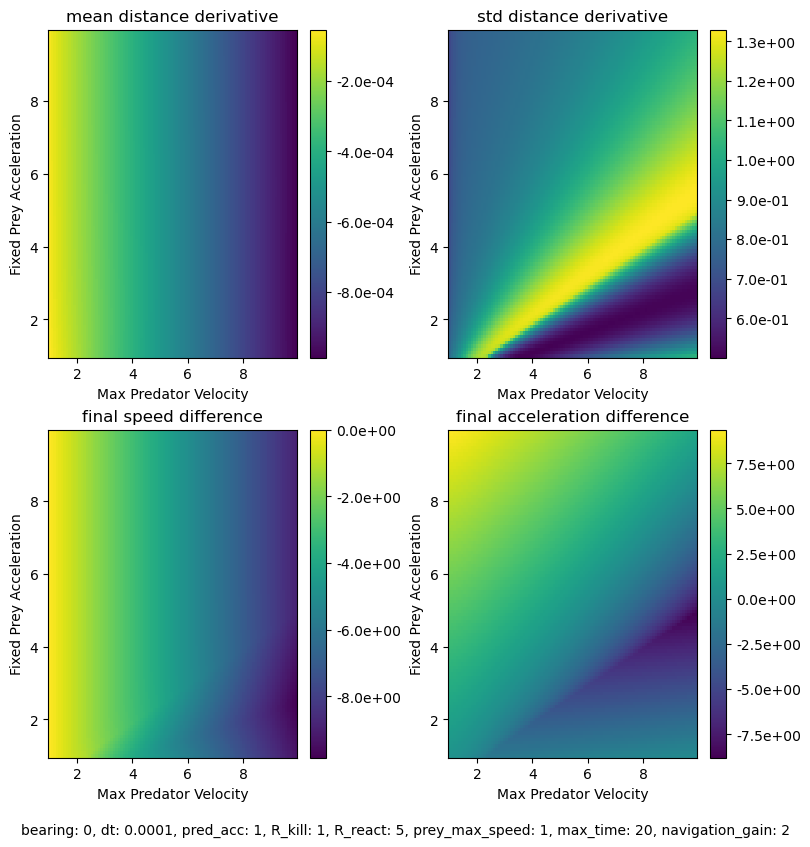

In [20]:
plot_3d_array_slices(result_grid[:, :, 6:10], parameters, 
                     titles = get_phase_titles()[6:10],   
                     x=v_range, 
                     y=a_range,
                     ncols=2)

As a final remark, we observe that distance always decreases over the runs, with a faster initial rate at the beginning, regardless of prey acceleration, and lowers near the end. Similarly, the final difference between the speeds decreases, though it generally remains negative, as the predator is faster. 

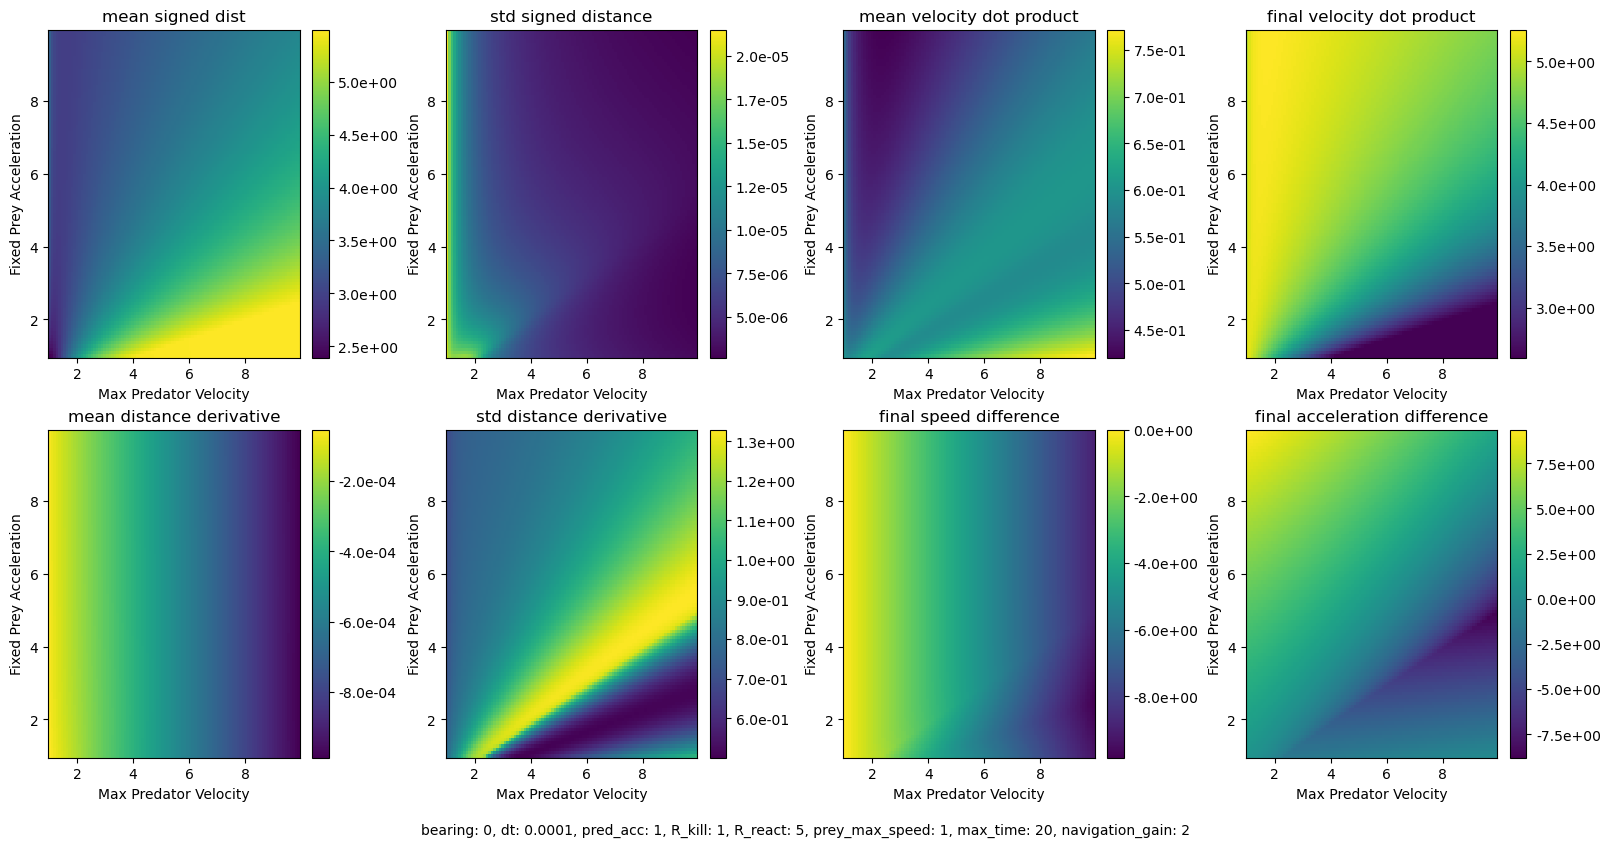

In [21]:
plot_3d_array_slices(result_grid[:, :, 2:], parameters, 
                     titles = get_phase_titles()[2:],   
                     x=v_range, 
                     y=a_range,
                     ncols=4)

# Conclusion
The Homicidal Chauffeur Problem in 2D exhibits a rich variety of behaviours, even when reduced to 'simple' and deterministic decision rules for both prey and predator. In our investigation, we picked right-angle evasion for the prey and Proportional Navigation for the predator; after defining the setting and assumptions, we identified relevant metrics for studying the trajectories: signed and unsigned distances are qualitative indicators of the efficiency of the chase, while the dot product between the velocities highlights alignment between the agents. We compared variations of signed distances through an activation function and applied the cosine transform to study single trajectories, concluding that the most informative log-log plot may be produced through a Hamming window function applied to the positive distance metric. Finally, we picked a region of the parameter space and for fixed initial conditions we varied predator maximum speed and prey acceleration. We identified a symmetric basin of behaviours, in which predators that are fast enough in relation to the prey's acceleration chase it in parallel but intercept it at a steep angle of attack, while the opposite phenomenon occurs in the reverse.